In [ ]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import diffrax as dfx
import optax
import numpy as np 
import matplotlib.pyplot as plt
from chainconsumer import Chain, ChainConsumer

from configs import make_dirs
from configs.shear import shear
from data.shear import get_shear_experiment, get_experiment_data

from sbiax.utils import make_df
from sbiax.ndes import Ensemble, CNF, Scaler
from sbiax.train import train_ensemble
from sbiax.compression.linear import _mle
from sbiax.inference.nle import nuts_sample

Here we run density-estimation SBI on a datavector made up of cosmic shear two-point functions.

Our `config` object contains all the properties of the models, training and sampling. You could use all its properties without the `config` object itself.

In [2]:
config = shear()

key = jr.key(config.seed)
key, model_key, train_key, sample_key = jr.split(key, 4)

In [3]:
# Location of results / saving
results_dir  = (
    "/Users/Jed.Homer/phd/sbiax/results/" +  # Import this from a constants file
    f"{config.sbi_type}/" + 
    f"{config.exp_name}/" + 
    f"{config.model.model_type}/" + 
    f"{config.seed}/"
)
make_dirs(results_dir)

RESULTS_DIR:
 /Users/Jed.Homer/phd/sbiax/results/nle/shear/cnf/0/


Here we sample a set of $n_s$ simulations from the true data likelihood $\mathcal{G}[\hat{\xi}|\xi[\pi], \Sigma]$ for training the normalising flow models.

In [4]:
(
    alpha,                  # True parameters
    parameter_names,        # Parameter names
    mu,                     # Model expectation
    covariance,             # Data covariance
    precision,              # Inverse data covariance
    dmu,                    # Theory derivatives
    F,                      # Fisher information
    Finv,                   # Inverse Fisher information 
    lower,                  # Lower prior bounds
    upper                   # Upper prior bounds
) = get_shear_experiment()

(
    X, 
    Y, 
    covariance_est, 
    Finv_est,
    precision_est,
    parameter_prior
) = get_experiment_data(
    key=key,
    good=True,
    n_sims=config.n_s,
    n_obs=1,
    results_dir=results_dir
)

In this experiment we will use a linear compression parameterised by the true data covariance $\Sigma$.

It is common in practice to use an estimate of the covariance from a finite set of simulations.

Our compression is written as $\hat{\pi} = \pi + F_{\Sigma}^{-1}E\Sigma^{-1}(\hat{\xi} - \xi[\pi])$ where $F_{\Sigma}^{-1}$ is the Fisher information matrix, $E$ is some matrix defining our model $\xi[\pi]=\pi^0 + (\pi - \pi^0)^TE$ which depends on a fiducial parameter set $\pi^0$.

Note that this implicitly assumes the model $\xi[\pi]$ is known and is perfectly accurate.

In [ ]:
s = lambda d, p: _mle(
    d,
    pi=p,
    Finv=Finv, 
    mu=mu + jnp.dot(p - alpha, dmu), 
    dmu=dmu, 
    precision=precision
)

Next we build the density-estimating normalising flows.

We'll use two continuous normalising flows and put them in an `Ensemble`. This object can pass through `jit` boundaries and has its own `log_prob` functions.

In [5]:
# Build neural density estimators
model_keys = jr.split(model_key, 2)

scaler = Scaler(X, Y, use_scaling=config.model.use_scaling)

solver = getattr(dfx, config.model.solver)()

ndes = [
    CNF(
        event_dim=alpha.size, 
        context_dim=alpha.size, 
        width_size=config.model.width_size,
        depth=config.model.depth, 
        solver=solver,
        activation=config.model.activation,
        dt=config.model.dt, 
        t1=config.model.t1, 
        dropout_rate=config.model.dropout_rate,
        exact_log_prob=config.model.exact_log_prob,
        scaler=scaler,
        key=key
    )
    for key in model_keys
]

ensemble = Ensemble(ndes, sbi_type=config.sbi_type)

Now we fit the flow ensemble to the compressed simulations

In [6]:
opt = getattr(optax, config.opt)(config.lr)

ensemble, stats = train_ensemble(
    train_key, 
    ensemble,
    train_mode=config.sbi_type,
    train_data=[X, Y], 
    opt=opt,
    n_batch=config.n_batch,
    patience=config.patience,
    n_epochs=config.n_epochs,
    results_dir=results_dir
)

NDE has n_params=51.


Training terminated early at epoch 1317; valid=-7.178E+00, train=-7.282E+00.:  13%|█▎        | 1316/10000 [02:07<13:58, 10.35epoch/s, train=-7.282E+00, valid=-7.178E+00, best_valid=-7.278E+00, stop=0000]


NDE has n_params=51.


Training terminated early at epoch 1654; valid=-8.396E+00, train=-8.317E+00.:  17%|█▋        | 1653/10000 [02:40<13:30, 10.30epoch/s, train=-8.317E+00, valid=-8.396E+00, best_valid=-8.419E+00, stop=0000]


Weights: [0.24061398 0.759386  ]


Now we sample a measurement to condition our posterior with. This noisy datavector is from the same likelihood above, and we pass it to the `Ensemble` likelihood function.

This `log_prob` function is sampled via the `nuts_sample` function below.

In [7]:
# Get a noisy datavector with different alpha parameters
key_data, key_state, key_sample = jr.split(sample_key, 3)

# Generates datavector d ~ G[d|xi[pi], Sigma]
datavector = jr.multivariate_normal(key_data, mu, covariance)

# Linear summary
X_ = s(datavector, alpha)

# Initial state of MCMC walkers
state = jr.multivariate_normal(
    key_state, X_, Finv, (2 * config.n_walkers,)
)

ensemble = eqx.nn.inference_mode(ensemble)

log_prob_fn = ensemble.ensemble_log_prob_fn(X_, parameter_prior)

In [8]:
samples, samples_log_prob = nuts_sample(
    key_sample, log_prob_fn, prior=parameter_prior
)

Finally we plot the posterior. Nothing fancy here, we simply use `chainconsumer` to plot our chains. 

The `Ensemble` likelihood chain is compared to a Fisher forecast - which is the analytic solution to this inference problem given the Gaussian errors and linear model.

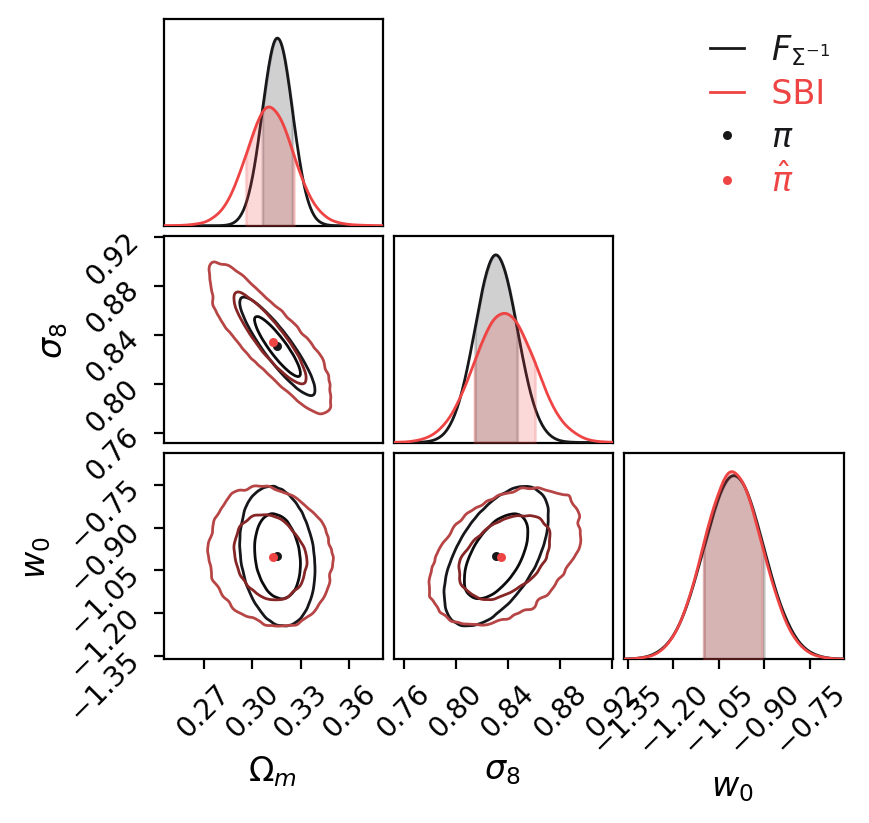

In [9]:
c = ChainConsumer()

c.add_chain(
    Chain.from_covariance(
        alpha,
        Finv,
        columns=parameter_names,
        name=r"$F_{\Sigma^{-1}}$",
        color="k",
        shade_alpha=0.
    )
)
c.add_chain(
    Chain(
        samples=make_df(samples, samples_log_prob, parameter_names), 
        name="SBI", 
        color="r", 
        shade_alpha=0.
    )
)
c.add_marker(
    location=dict(zip(parameter_names, np.asarray(alpha))), name=r"$\pi$", color="k"
)
c.add_marker(
    location=dict(zip(parameter_names, np.asarray(X_))), name=r"$\hat{\pi}$", color="r"
)

fig = c.plotter.plot()
fig.set_dpi(200)
fig.set_figheight(4.5)
fig.set_figwidth(4.5)
plt.show()